In [1]:
from config import *

import bs4
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from typing_extensions import List, TypedDict, Annotated
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, trim_messages

/Users/zhengjie/Documents/learn-langchain/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
USER_AGENT environment variable not set, consider setting it to identify your requests.


# 获取网页内容

这一部分我们将从网页中提取文本，然后将其分成小块，以便逐步翻译。

In [2]:
bs4_strainer = bs4.SoupStrainer(class_=("md-content__inner md-typeset"))
loader = WebBaseLoader(
    web_paths=("https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=0,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document

)
all_splits = text_splitter.split_documents(docs)

# 建立翻译机制

我们将使用一个简单的状态机来处理翻译任务。我们将从一个系统消息开始，制定翻译规则，然后逐步翻译文档的每个部分。

In [3]:
prompt = SystemMessage("您是一名精通多领域的技术文档翻译专家，需要将英文技术文档翻译成中文。\n"
                       "你需要遵循以下规则:\n"
                       "1. 使用Markdown格式对文档进行排版，各级标题需要使用相应的格式（如“#”、“##”），这一点很重要。\n"
                       "2. 有关代码的部分不需要进行翻译，包括代码的注释。\n"
                       "3. 只需要翻译我给你的内容，不要去创作、不要闲聊。\n"
                       "4. 请尽量保持翻译的准确性和流畅性。\n"
                       "最后，再次提醒，翻译的结果要用Markdown格式。\n")

In [4]:
class State(TypedDict):
    num: int
    translated_splits: Annotated[List[AnyMessage], add_messages]
    messages: Annotated[List[AnyMessage], add_messages]
    translated: str

In [5]:
def ask_for_translation(state: State):
    return {
        "messages": [HumanMessage(all_splits[state['num']].page_content)]
    }


def translate(state: State):
    messages = trim_messages(state['messages'],
                             max_tokens=3,
                             token_counter=len,
                             start_on="human",
                             end_on="human")

    # 每次传递的消息都是从当前状态开始（包含了 prompt 和之前的翻译）
    messages = [prompt] + messages

    # 获取模型的响应
    response = llm.invoke(messages)

    # 修复：确保我们只将当前翻译的结果返回，而不重复之前的翻译
    return {
        "messages": [response],
        "translated_splits": [response],  # 只返回当前分块的翻译
        "num": state['num'] + 1  # 更新索引，确保不会重复处理已翻译的分块
    }


def collect(state: State):
    return {
        "translated": "\n".join([m.content for m in state['translated_splits']])
    }


def route(state: State):
    # 当所有分块都已翻译时，结束处理
    if state['num'] < 3:
        return "ask_for_translation"
    else:
        return "collect"

构建状态图，添加节点和边

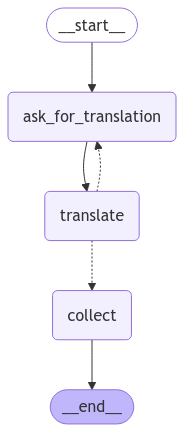

In [6]:
# 初始化 LLM 模型
llm = ChatOpenAI(model="qwen-max")

# 创建状态图
graph_builder = StateGraph(State)
graph_builder.add_node("ask_for_translation", ask_for_translation)
graph_builder.add_node("translate", translate)
graph_builder.add_node("collect", collect)

# 定义节点之间的流动关系
graph_builder.add_edge(START, "ask_for_translation")
graph_builder.add_edge("ask_for_translation", "translate")
graph_builder.add_conditional_edges("translate", route,
                                    {"ask_for_translation": "ask_for_translation",
                                     "collect": "collect"})
graph_builder.add_edge("collect", END)

# 编译状态图
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 展示翻译结果

In [7]:
# 流式执行并打印每个步骤的输出
inputs = {"num": 0, "translated_splits": [], "messages": []}
result = graph.invoke(inputs)

In [8]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Build a Customer Support Bot¶
Customer support bots can free up teams' time by handling routine issues, but it can be hard to build a bot that reliably handles diverse tasks in a way that doesn't leave the user pulling their hair out.
In this tutorial, you will build a customer support bot for an airline to help users research and make travel arrangements. You'll learn to use LangGraph's interrupts and checkpointers and more complex state to organize your assistant's tools and manage a user's flight bookings, hotel reservations, car rentals, and excursions. It assumes you are familiar with the concepts presented in the LangGraph introductory tutorial.
By the end, you'll have built a working bot and gained an understanding of  LangGraph's key concepts and architectures. You'll be able to apply these design patterns to your other AI projects.
Your final chat bot will look something like the following diagra

In [9]:
from IPython.display import Markdown, display

display(Markdown(result["translated"]))

# 构建客户服务机器人
客户服务机器人可以通过处理日常问题来节省团队的时间，但构建一个能够可靠地处理各种任务且不会让用户感到沮丧的机器人可能很难。
在本教程中，你将为一家航空公司构建一个客户服务机器人，以帮助用户研究和安排旅行。你将学习如何使用LangGraph的中断和检查点以及更复杂的状态来组织助手的工具，并管理用户的航班预订、酒店预订、租车服务和旅游活动。本教程假设你已经熟悉了LangGraph入门教程中介绍的概念。
到最后，你将构建出一个可以工作的机器人，并对LangGraph的关键概念和架构有了一定的理解。你将能够把这些设计模式应用到你的其他AI项目中。
最终你的聊天机器人的外观将会类似于下面的示意图：
# 让我们开始吧！

## 先决条件
首先，设置你的环境。我们将安装本教程所需的先决条件，下载测试数据库，并定义将在每个部分中重用的工具。
我们将使用Claude作为我们的LLM，并定义一些自定义工具。虽然大多数工具将连接到本地sqlite数据库（不需要额外的依赖项），但我们也将会通过Tavily为代理提供一个通用的网络搜索功能。

```python
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain-anthropic tavily-python pandas openai

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
```

### 为LangGraph开发设置LangSmith
## 注册LangSmith
注册LangSmith，以便快速发现并解决你的LangGraph项目中的问题，并提高性能。LangSmith允许你使用跟踪数据来调试、测试和监控使用LangGraph构建的LLM应用程序——[在这里](#)阅读更多关于如何开始的信息。

## 填充数据库
运行以下脚本来获取我们为本教程准备的sqlite数据库，并更新它使其看起来是当前的。具体细节不重要。

```python
import os
import shutil
import sqlite3

import pandas as pd
import requests
```